# Figure 6: Implications of the uncovered treatment dynamics for adaptive therapy

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp
import datetime
import scipy.stats as stats

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import PlotFit, PlotData, LoadFit, compute_confidenceInterval_prediction

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [2]:
# Data and solver configurations
cellLine = "OVCAR3"
n_bootstraps = 250 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}

# Load Model 5
modelName = "CycleArrestModel_singleStep_extraDivs_dr"
modelDir = "./fits/"
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)
treatmentModelBootstrapsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

# Mouse data
dataDf_oc3 = pd.read_csv("./data/mouseDataDf_oc3.csv",index_col=0)
# The AT2 mice had to be taken down at 79 days. The rest were continued out of interest, but these data 
# were not further analysed for this paper.
dataDf_oc3 = dataDf_oc3[dataDf_oc3.Time<80].copy()

# Environment
nProcesses = 4 # Number of cores to use for bootstrapping
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}
myColourPlatte = {'Ctrl':"#929591",'MTD':"#FF9409",'AT1':'#029386','AT2':sns.xkcd_rgb["dark pink"]}
plottingOrder = ['Ctrl','MTD','AT1','AT2']

## b) Plot model predictions for AT1 and AT2

In [32]:
n0 = 5
fA = 0
intervalLength = 3 # how frequently treatment is adjusted (in days)
t_end = 60 # simulation time length (in days)
fitObj, model = LoadFit(modelName, fitDir=currOutDir)
DMax = model.paramDic['DMax']

### Simulate

In [42]:
#                      "AT1":{'doseAdjustFac':2, 'atThreshold':0., 'mode':"mehdi",
#                          'D0':DMax, 'v_min':n0/2, 'intervalLength':intervalLength, 
#                          't_end':t_end},

algorithmSpecsDic = {"AT1":{'atThreshold':0., 'doseList':[0,12.5,25,50,100],
                         'D0':DMax, 'intervalLength':intervalLength, 
                         't_end':t_end},
                     "AT2":{'atThreshold':0., 'n_days_lookback':1,
                            'D0':DMax, 'intervalLength':intervalLength, 
                            't_end':t_end},
                     "CT":{'atThreshold':1., 'doseList':[100],
                           'D0':DMax, 'intervalLength':intervalLength, 
                           't_end':t_end}}

In [43]:
tmpDfList = []
for algorithm in list(algorithmSpecsDic.keys()):
    # Simulate
    atToProfile = algorithm if algorithm!="CT" else "AT1"
    tmpDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                 bootstrapResultsDf=treatmentModelBootstrapsDf[:n_bootstraps],
                                                 atToProfile=atToProfile,
                                                 at_kws=algorithmSpecsDic[algorithm],
                                                 initialConditionsList={"P0":(1-fA)*n0, "A0":fA*n0},
                                                 show_progress=True, n_time_steps=100,
                                                 alpha=ci_significanceLevel,
                                                 solver_kws=solver_kws)
    tmpDf['Algorithm'] = algorithm
    tmpDfList.append(tmpDf)
modelPredictionsDf = pd.concat(tmpDfList)

100%|██████████| 250/250 [00:56<00:00,  4.43it/s]


### Plot

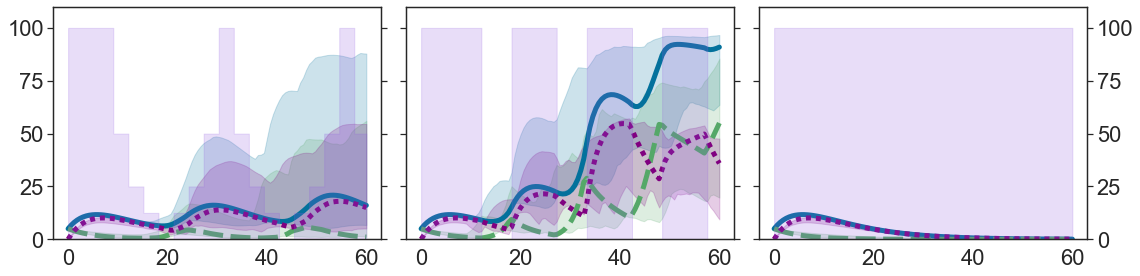

In [44]:
# fig,axList = plt.subplots(1,1,figsize=(8,6))
fig,axList = plt.subplots(1,3,sharex=True,sharey=True,figsize=(16,4))
for i,algorithm in enumerate(algorithmSpecsDic.keys()):
    currModelDataDf = modelPredictionsDf[modelPredictionsDf.Algorithm==algorithm]
    # Plot
    ax = axList[i]
    # 1. Plot the model predictions and associated confidence intervals
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=cycleArrestModelPalette,
                 legend=False,
                 data=currModelDataDf, ax=ax)
    for var in cycleArrestModelPalette.keys():
        currDataDf = currModelDataDf[currModelDataDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
    # 2. Plot the drug concentration for the simulation based on the MLE
    tmpDf = currModelDataDf.copy()
    tmpDf['Confluence'] = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=algorithm=="CT", ax=ax)
    ax.tick_params(labelsize=22)
    ax.set_ylim(0,110)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax2 = ax.get_shared_x_axes().get_siblings(ax)[-1]
    ax2.tick_params(labelsize=22)
plt.tight_layout()
plt.savefig("./figures/txPredictions_differentATAlgorithms.pdf")

## c) Mouse data

In [7]:
# Standardise time to start of tx
# Tumours were seeded on 2019.12.11 and treatment was started on 2019/12/27
treatmentStartDate = datetime.datetime.strptime("2019/12/27","%Y/%m/%d") - datetime.datetime.strptime("2019/12/11","%Y/%m/%d") 
dataDf_oc3_normalised = dataDf_oc3[dataDf_oc3.Time>=treatmentStartDate.days].copy()
dataDf_oc3_normalised['Time'] -= treatmentStartDate.days

offsetDic = dict(zip(['Ctrl','MTD','AT1','AT2'],np.linspace(-0.2,0.2,4)))

# Compute the average tumour size per week. Only keep data for which there are at least 3 mice per week.
tmpDfList = []
for i,txName in enumerate(['Ctrl','MTD','AT1','AT2']):
    tmpDicList = []
    samplesPerWeekDic = {i:0 for i in range(0,20)}
    mouseList = dataDf_oc3_normalised.MouseId[dataDf_oc3_normalised.TreatmentBranch==txName].unique()
    for j,mouse in enumerate(mouseList):
        currDataDf = dataDf_oc3_normalised[dataDf_oc3_normalised.MouseId==mouse].copy()
        for flankId in ["Left","Right"]:
            currFlankData = currDataDf[(currDataDf.Flank==flankId) & 
                                       (np.isnan(currDataDf.Volume)==False)].copy()
            currFlankData['Time'] = currFlankData['Time'] // 7
            for week in currFlankData.Time.unique():
                if currFlankData.Volume[currFlankData.Time==week].shape[0] > 1:
                    meanVolume = np.mean(currFlankData.Volume[currFlankData.Time==week])
                    samplesPerWeekDic[week] += 1
                else:
                    meanVolume = np.NaN
                tmpDicList.append({"MouseId":mouse,
                                   "Flank":flankId,
                                   "Week":week,
                                   "Volume":meanVolume,
                                   "TreatmentBranch":currFlankData.TreatmentBranch.unique()[0]})
    tmpDf = pd.DataFrame(tmpDicList)
    maxWeek = max([k for k in samplesPerWeekDic.keys() if samplesPerWeekDic[k]>3])  
    tmpDf = tmpDf[tmpDf.Week<maxWeek]
    tmpDf['Week'] += offsetDic[txName]
    tmpDfList.append(tmpDf)
resultsDf_7dAverage = pd.concat(tmpDfList)
resultsDf_7dAverage.loc[resultsDf_7dAverage['Week']<1,'Week'] = 0

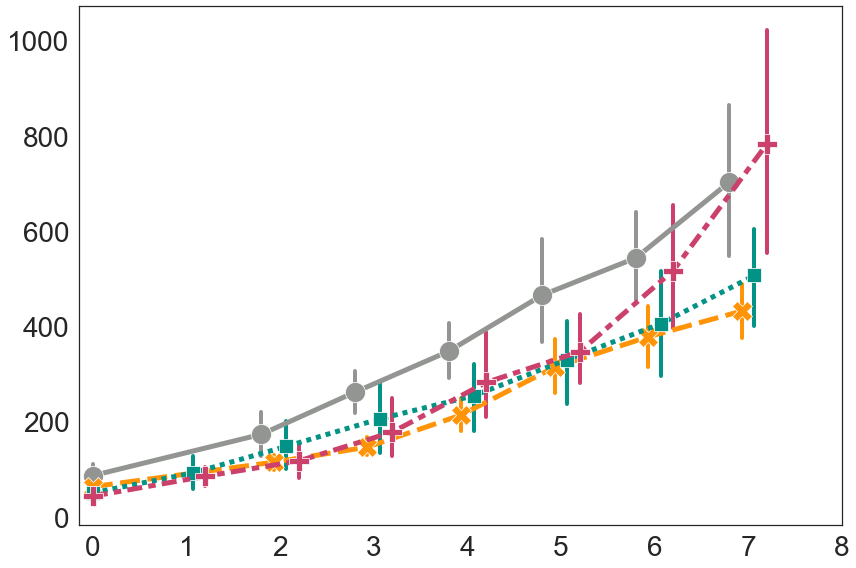

In [12]:
plt.figure(figsize=(12,8))
sns.lineplot(x="Week",y="Volume",
             hue="TreatmentBranch",style="TreatmentBranch", #estimator=None, units="MouseId",
             hue_order=plottingOrder,
             palette=myColourPlatte,
             style_order=plottingOrder,
             linewidth=5, markers=True, markersize=20,
             err_style='bars', err_kws={"elinewidth":4, "capsize":0},
             legend=None,
#              err_kws={'lolims':True,'barsabove':True},
             data=resultsDf_7dAverage)
plt.xlim(-0.15,8)
plt.ylabel(r"")
plt.xlabel("")
# sns.despine(offset=5, trim=True)
plt.tick_params(labelsize=28)
plt.tight_layout()
plt.savefig("figures/inVivoData_oc3.pdf")

Ctrl; Statistics: 0.83; p-value: 0.11
AT1; Statistics: 0.96; p-value: 0.78
AT2; Statistics: 0.81; p-value: 0.11
MTD; Statistics: 0.91; p-value: 0.44
('Ctrl', 'AT1'): ; Bartlett test: 0.79, t-test: 0.04
('Ctrl', 'AT2'): ; Bartlett test: 0.09, t-test: 0.69
('Ctrl', 'MTD'): ; Bartlett test: 0.17, t-test: 0.01
('AT1', 'AT2'): ; Bartlett test: 0.08, t-test: 0.14


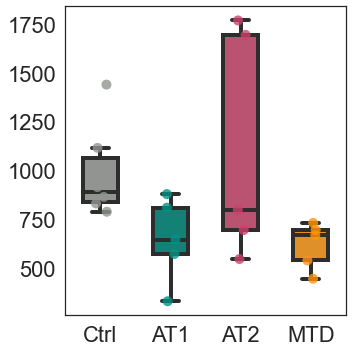

In [5]:
# Compare tumor sizes at the time when AT2 had to be taken down.
endTime_AT2 = dataDf_oc3[(dataDf_oc3.TreatmentBranch=="AT2") & 
                         (np.isnan(dataDf_oc3.Volume)==False)].Time.max()
dataToCompareDf = dataDf_oc3[(dataDf_oc3.Time==endTime_AT2) &
                             (dataDf_oc3.TreatmentBranch!="Math") &
                             (np.isnan(dataDf_oc3.Volume)==False)].copy()

# Plot points to make sure I'm looking at the right ones.
myColourPlatte = {'Ctrl':"#929591",'MTD':"#FF9409",'AT1':'#029386','AT2':sns.xkcd_rgb["dark pink"]}
plottingOrder = ['Ctrl','MTD','AT1','AT2']
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.stripplot(x="TreatmentBranch", y="Volume", 
          alpha=0.8,size=10,palette=myColourPlatte,
         ax=ax,data=dataToCompareDf)
sns.boxplot(x="TreatmentBranch", y="Volume", showfliers=False,
            palette=myColourPlatte,
            linewidth=4, width=0.5,
             ax=ax,data=dataToCompareDf)
# ax.set_title(title)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()

# Statistics.
# Shapiro-Wilk test for normality
for group in dataToCompareDf.TreatmentBranch.unique():
    swTest = stats.shapiro(dataToCompareDf[(dataToCompareDf.TreatmentBranch==group)
                                         & (np.isnan(dataToCompareDf.Volume)==False)].Volume.values)
    print("%s; Statistics: %1.2f; p-value: %1.2f"%(group,swTest[0],swTest[1]))

groupsToCompare = [("Ctrl","AT1"), ("Ctrl","AT2"), ("Ctrl","MTD"), ("AT1","AT2")]

# Pair-wise comparisons. Given all groups pass the normality test, we will use a parametric test.
# The Bartlett test tests for equal variance, and the results of this test are used to choose whether 
# or not to use a t-test (equal variance) or welch test (unequal variance).
for group in groupsToCompare:
    barTest = stats.bartlett(dataToCompareDf[dataToCompareDf.TreatmentBranch==group[0]].Volume.values, 
                    dataToCompareDf[dataToCompareDf.TreatmentBranch==group[1]].Volume.values)
    tTest = stats.ttest_ind(a=dataToCompareDf[dataToCompareDf.TreatmentBranch==group[0]].Volume.values, 
                    b=dataToCompareDf[dataToCompareDf.TreatmentBranch==group[1]].Volume.values,
                    equal_var=barTest[1]>0.05, nan_policy='omit')
    print("%s: ; Bartlett test: %1.2f, t-test: %1.2f"%(group,barTest[1],tTest[1]))

### Plot the average drug use

In [9]:
tmpDicList = []
for i,txName in enumerate(['Ctrl','MTD','AT1','AT2']):
    mouseList = dataDf_oc3.MouseId[dataDf_oc3.TreatmentBranch==txName].unique()
    for j,mouse in enumerate(mouseList):
        currDataDf = dataDf_oc3[(dataDf_oc3.MouseId==mouse)].copy()
        for flankId in currDataDf.Flank.unique():
            currFlankData = currDataDf[(currDataDf.Flank==flankId) & 
                                       (currDataDf.DrugConcentration!='X')].copy() # (np.isnan(currDataDf.Volume)==False)
        survivalTime = currFlankData.Time[currFlankData.Volume>0].max()
        tmpDicList.append({"MouseId":mouse,
                           "CumulativeDrug":np.sum(currFlankData.DrugConcentration.astype(float)),
                           "MeanDrug":np.sum(currFlankData.DrugConcentration.astype(float))/survivalTime,
                           "TreatmentBranch":currFlankData.TreatmentBranch.unique()[0]})

cumDrugDataDf = pd.DataFrame(tmpDicList)

/Users/Maxi/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


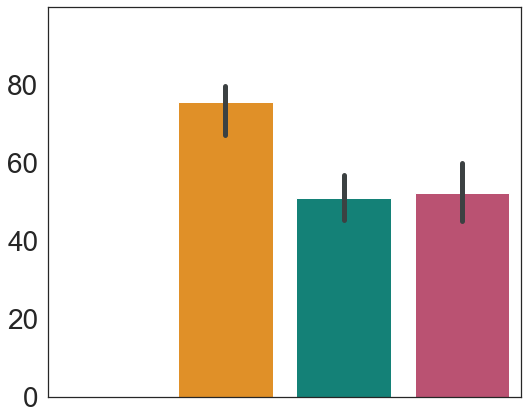

In [37]:
# Figure for ovarian collaboration meeting presentation 2021.08.27
plt.figure(figsize=(7.5,6))
ax = sns.barplot(x="TreatmentBranch", y="MeanDrug", 
                 errwidth=5, errcolor=sns.xkcd_rgb["charcoal grey"],
                 palette=myColourPlatte,
                 data=cumDrugDataDf)
ax.set_ylim(0,100)
ax.set_ylabel("")
ax.set_xlabel(r"")
ax.set_xticklabels([])
ax.set_yticklabels([0,20,40,60,80,])
# sns.despine(offset=5, trim=True)
plt.tick_params(labelsize=28)
plt.xticks(rotation=315)
plt.tight_layout()
plt.savefig("figures/inVivoData_meanDrug_oc3.pdf")

In [20]:
# Statistics.
# Shapiro-Wilk test for normality
for group in ["MTD", "AT1", "AT2"]:
    swTest = stats.shapiro(cumDrugDataDf[(cumDrugDataDf.TreatmentBranch==group)].MeanDrug.values)
    print("%s; Statistics: %1.2f; p-value: %1.2f"%(group,swTest[0],swTest[1]))

groupsToCompare = [("MTD","AT1"), ("MTD","AT2"), ("AT1","AT2")]

# Pair-wise comparisons. Given all groups pass the normality test, we will use a parametric test.
# The Bartlett test tests for equal variance, and the results of this test are used to choose whether 
# or not to use a t-test (equal variance) or welch test (unequal variance).
for group in groupsToCompare:
    barTest = stats.bartlett(cumDrugDataDf[cumDrugDataDf.TreatmentBranch==group[0]].MeanDrug.values, 
                    cumDrugDataDf[cumDrugDataDf.TreatmentBranch==group[1]].MeanDrug.values)
    tTest = stats.ttest_ind(a=cumDrugDataDf[cumDrugDataDf.TreatmentBranch==group[0]].MeanDrug.values, 
                    b=cumDrugDataDf[cumDrugDataDf.TreatmentBranch==group[1]].MeanDrug.values,
                    equal_var=barTest[1]>=0.05, nan_policy='omit')
    print("%s: ; Bartlett test: %1.2f, t-test: %1.3f"%(group,barTest[1],tTest[1]))

MTD; Statistics: 0.50; p-value: 0.00
AT1; Statistics: 0.87; p-value: 0.21
AT2; Statistics: 0.93; p-value: 0.56
('MTD', 'AT1'): ; Bartlett test: 0.69, t-test: 0.001
('MTD', 'AT2'): ; Bartlett test: 0.99, t-test: 0.003
('AT1', 'AT2'): ; Bartlett test: 0.69, t-test: 0.824
